In [18]:
from data_treat.get_ready_data import get_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from data_treat.data_normalizer import CustomNormalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

In [19]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order", "fraud"]

In [20]:
data = get_data()
pd.value_counts(data['fraud'])

0.0    87403
1.0    87403
Name: fraud, dtype: int64

In [21]:
data.values

array([[ 0.58189057,  0.63481628,  2.61856761, ...,  1.        ,
         1.        ,  0.        ],
       [11.82737126, 11.32580071,  4.90825631, ...,  0.        ,
         1.        ,  1.        ],
       [91.93273374, 60.61943711, 12.60045712, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 3.28033205,  5.2351786 ,  4.42495785, ...,  0.        ,
         1.        ,  1.        ],
       [ 6.11657299,  1.44857809,  4.12829049, ...,  0.        ,
         1.        ,  1.        ],
       [ 5.69811459,  0.11971158,  0.20502942, ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
13798,0.581891,0.634816,2.618568,0.0,1.0,1.0,1.0,0.0
138060,11.827371,11.325801,4.908256,1.0,1.0,0.0,1.0,1.0
217704,91.932734,60.619437,12.600457,1.0,0.0,0.0,1.0,1.0
895394,1.388012,0.136348,9.288531,0.0,0.0,0.0,1.0,1.0
79748,17.650940,0.250955,1.436782,1.0,0.0,0.0,1.0,0.0


In [23]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)


In [24]:
labels.head()


13798     0.0
138060    1.0
217704    1.0
895394    1.0
79748     0.0
Name: fraud, dtype: float64

In [25]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
13798,0.581891,0.634816,2.618568,0.0,1.0,1.0,1.0
138060,11.827371,11.325801,4.908256,1.0,1.0,0.0,1.0
217704,91.932734,60.619437,12.600457,1.0,0.0,0.0,1.0
895394,1.388012,0.136348,9.288531,0.0,0.0,0.0,1.0
79748,17.650940,0.250955,1.436782,1.0,0.0,0.0,1.0


In [26]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

Для сырых(не стандартизированных, нормализованных данных)

(0.9699709699453551, {'n_neighbors': 1})
[[27563  1336]
 [  360 28427]]


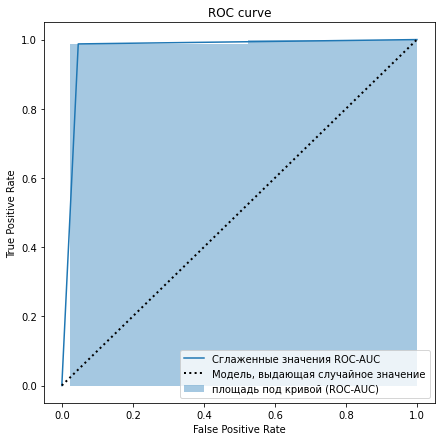

ROC-AUC на тестовой выборке: 0.9706321908676802


In [27]:
def gridSearch(X,y):

    param_dict = {
    'n_neighbors': np.arange(1,3,1),
    }
    model = KNeighborsClassifier()
    gv = GridSearchCV(model,param_grid=param_dict)
    gv.fit(X,y)
    return gv.best_score_,gv.best_params_



params = gridSearch(x_train, y_train)
print(params)

model = KNeighborsClassifier(n_neighbors=params[1]['n_neighbors'])
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print("Accuracy : ",accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test, predictions))

test_probabilities = model.predict_proba(x_test)
test_probabilities = test_probabilities[:, 1]
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

roc_auc_value = roc_auc_score(y_test, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value)

Для нормализованных данных

(0.9966700819672131, {'n_neighbors': 1})
[[23422  5477]
 [  205 28582]]


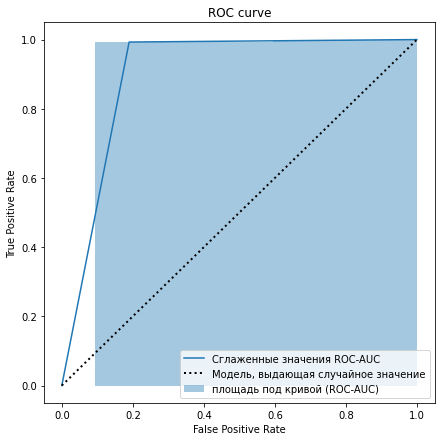

ROC-AUC на тестовой выборке: 0.90167830059445


In [28]:
def gridSearch(X,y):

    param_dict = {
    'n_neighbors': np.arange(1,3,1),
    }
    model = KNeighborsClassifier()
    gv = GridSearchCV(model,param_grid=param_dict)
    gv.fit(X,y)
    return gv.best_score_,gv.best_params_

X_train_n = CustomNormalizer.normalize(x_train)

X_test_n = CustomNormalizer.normalize(x_test)

params = gridSearch(X_train_n, y_train)
print(params)

model = KNeighborsClassifier(n_neighbors=params[1]['n_neighbors'])
model.fit(X_train_n, y_train)
predictions = model.predict(X_test_n)

print("Accuracy : ",accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test, predictions))

test_probabilities = model.predict_proba(X_test_n)
test_probabilities = test_probabilities[:, 1]
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

roc_auc_value = roc_auc_score(y_test, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value)

Для стандартизированных данных


(0.9966700819672131, {'n_neighbors': 1})
Accuracy :  90.15012308012342
[[23422  5477]
 [  205 28582]]


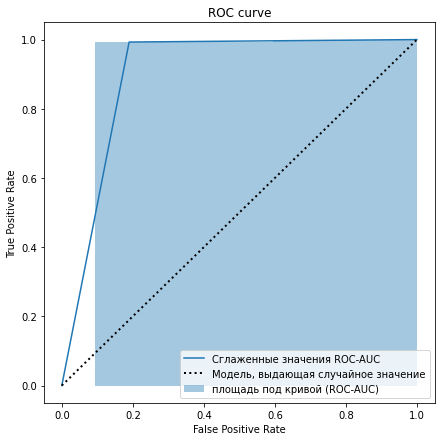

ROC-AUC на тестовой выборке: 0.90167830059445


In [31]:
def gridSearch(X,y):

    param_dict = {
    'n_neighbors': np.arange(1,2,1),
    }
    model = KNeighborsClassifier()
    gv = GridSearchCV(model,param_grid=param_dict)
    gv.fit(X,y)
    return gv.best_score_,gv.best_params_

X_train_s = CustomNormalizer.standardize(x_train)

X_test_s = CustomNormalizer.standardize(x_test)

params = gridSearch(X_train_s, y_train)
print(params)

model = KNeighborsClassifier(n_neighbors=params[1]['n_neighbors'])
model.fit(X_train_s, y_train)
predictions = model.predict(X_test_s)

print("Accuracy : ",accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test, predictions))

test_probabilities = model.predict_proba(X_test_s)
test_probabilities = test_probabilities[:, 1]
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

roc_auc_value = roc_auc_score(y_test, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value)